<a href="https://colab.research.google.com/github/Capstone-RSD/.github/blob/main/road1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# clone YOLOv5 repository
# mount Google drive and create a "Road" directory
%cd /content/drive/MyDrive/Road
!pwd
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard fbe67e465375231474a2ad80a4389efc77ecff99

/content/drive/MyDrive/Road
/content/drive/MyDrive/Road
fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/drive/MyDrive/Road/yolov5
HEAD is now at fbe67e4 Fix `OMP_NUM_THREADS=1` for macOS (#8624)


In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     |████████████████████████████████| 1.6 MB 5.1 MB/s 
Setup complete. Using torch 1.13.0+cu116 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="roboflow-yolov5")

     |████████████████████████████████| 42 kB 804 kB/s 
     |████████████████████████████████| 67 kB 5.8 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 178 kB 40.1 MB/s 
     |████████████████████████████████| 145 kB 81.8 MB/s 
     |████████████████████████████████| 138 kB 71.3 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=yolov5&ref=roboflow-yolov5


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="cWbrW60dsEnAget6vKGJ")
project = rf.workspace("wzhen-vt-edu").project("pavement-cracks-2wi3m")
dataset = project.version(1).download("yolov5")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to pavement-cracks-1 in yolov5pytorch:: 100%|██████████| 7840/7840 [08:33<00:00, 15.26it/s] 


In [ ]:
!pwd
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

/content/drive/MyDrive/Road/yolov5
names:
- alligator cracking
- edge cracking
- longitudinal cracking
- patching
- pothole
- rutting
- transverse cracking
nc: 7
train: pavement-cracks-1/train/images
val: pavement-cracks-1/valid/images


In [ ]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])
    print(num_classes)

7


In [ ]:
%cat /content/drive/MyDrive/Road/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/drive/MyDrive/Road/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
%cat /content/drive/MyDrive/Road/yolov5/models/yolov5s.yaml


# parameters
nc: 7  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/drive/MyDrive/Road/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/drive/MyDrive/Road/yolov5
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/content/drive/MyDrive/Road/yolov5/pavement-cracks-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 406 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup

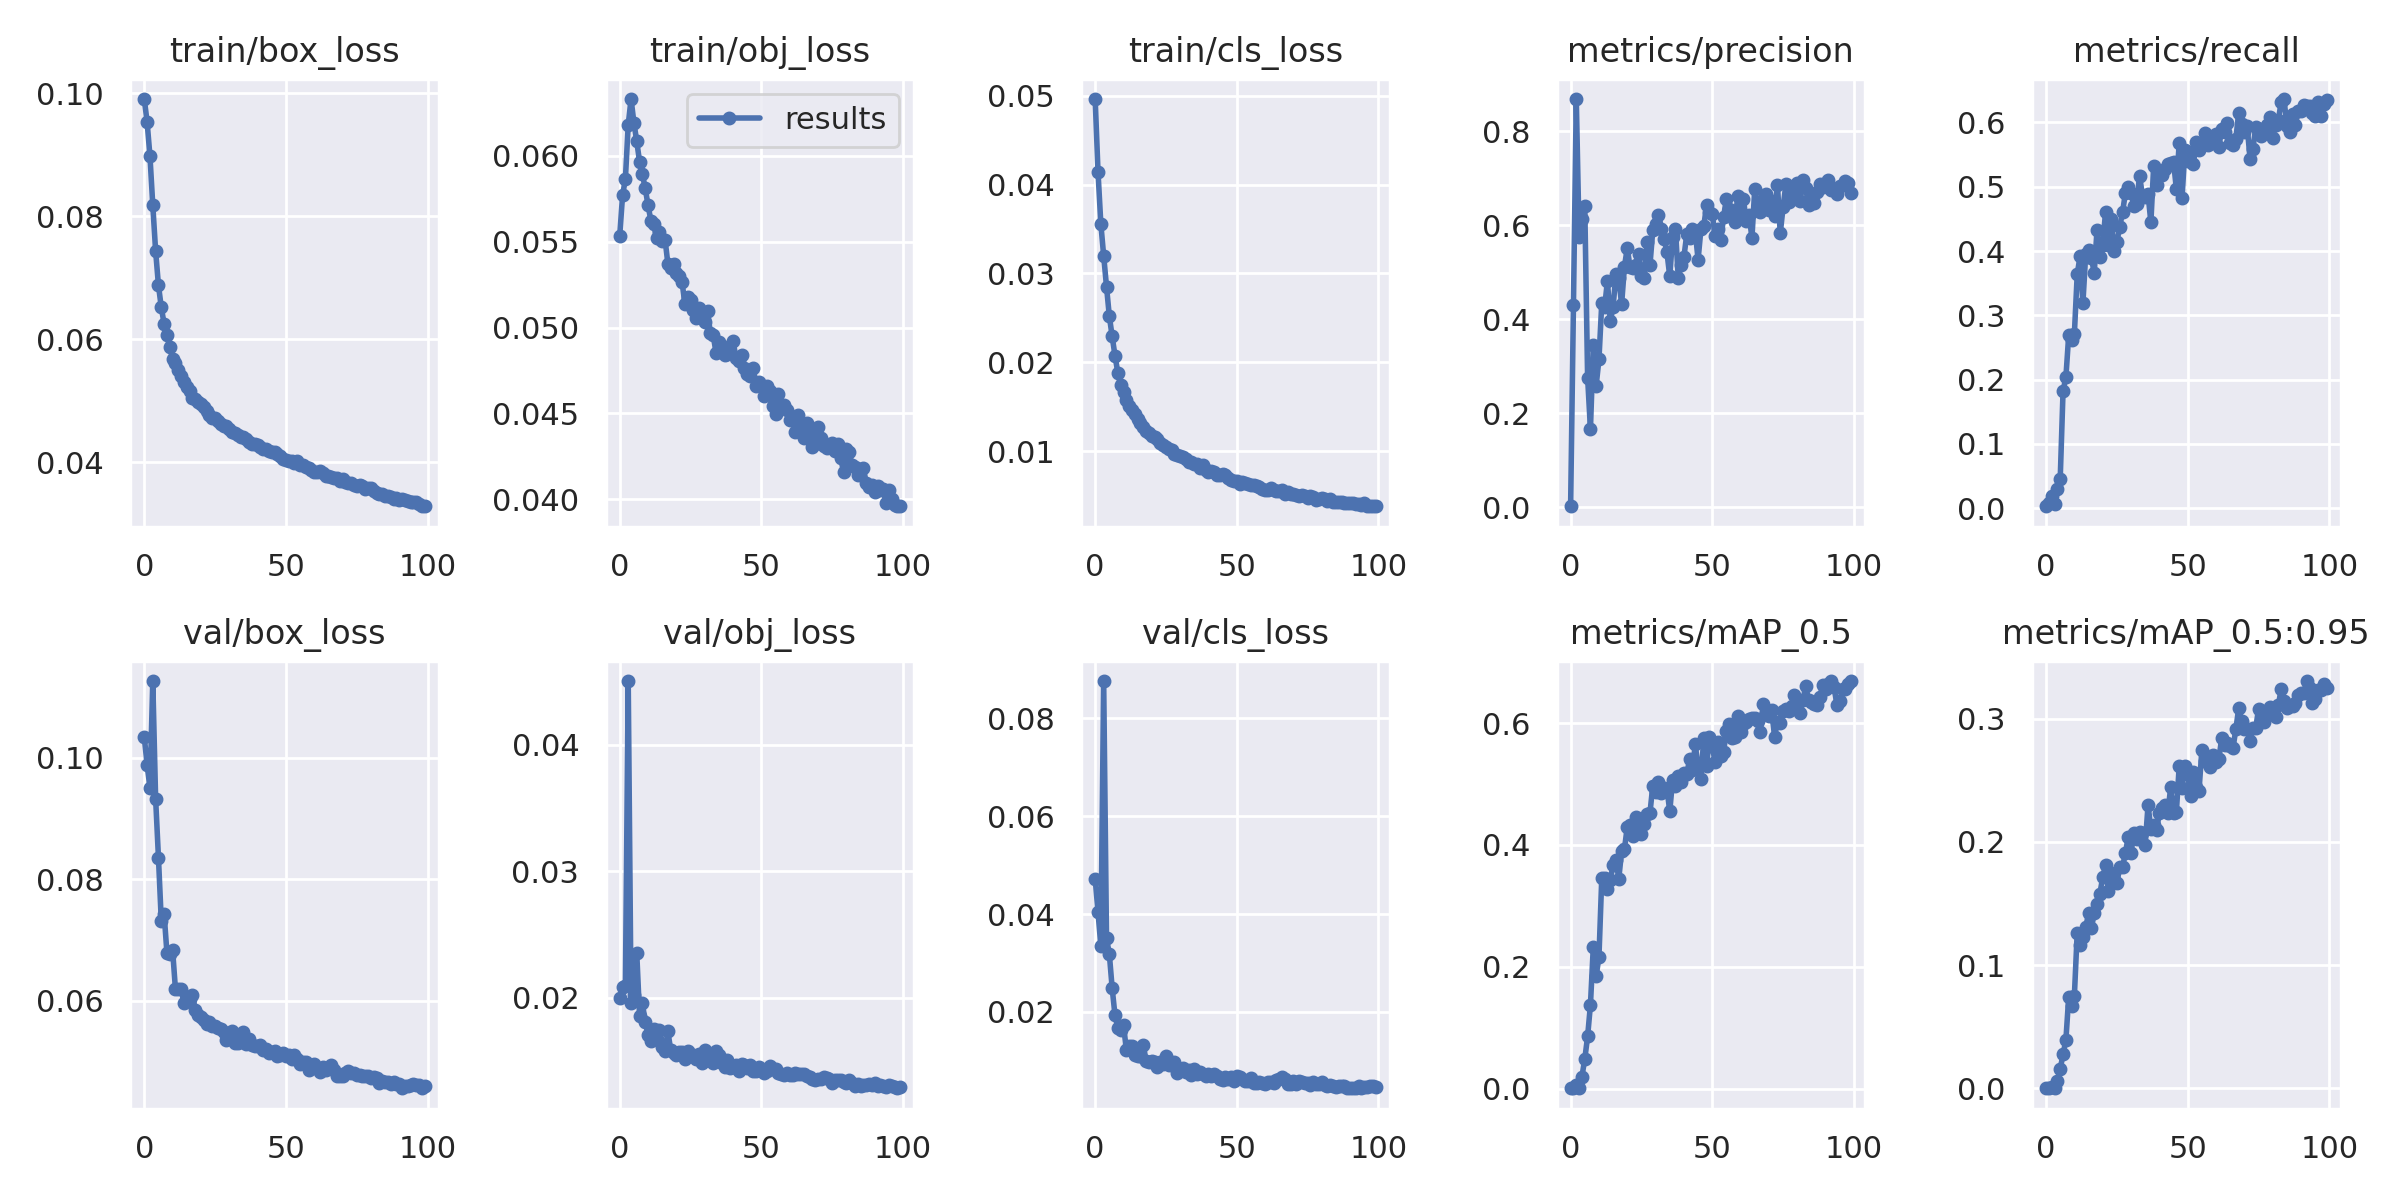

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/drive/MyDrive/Road/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

GROUND TRUTH TRAINING DATA:


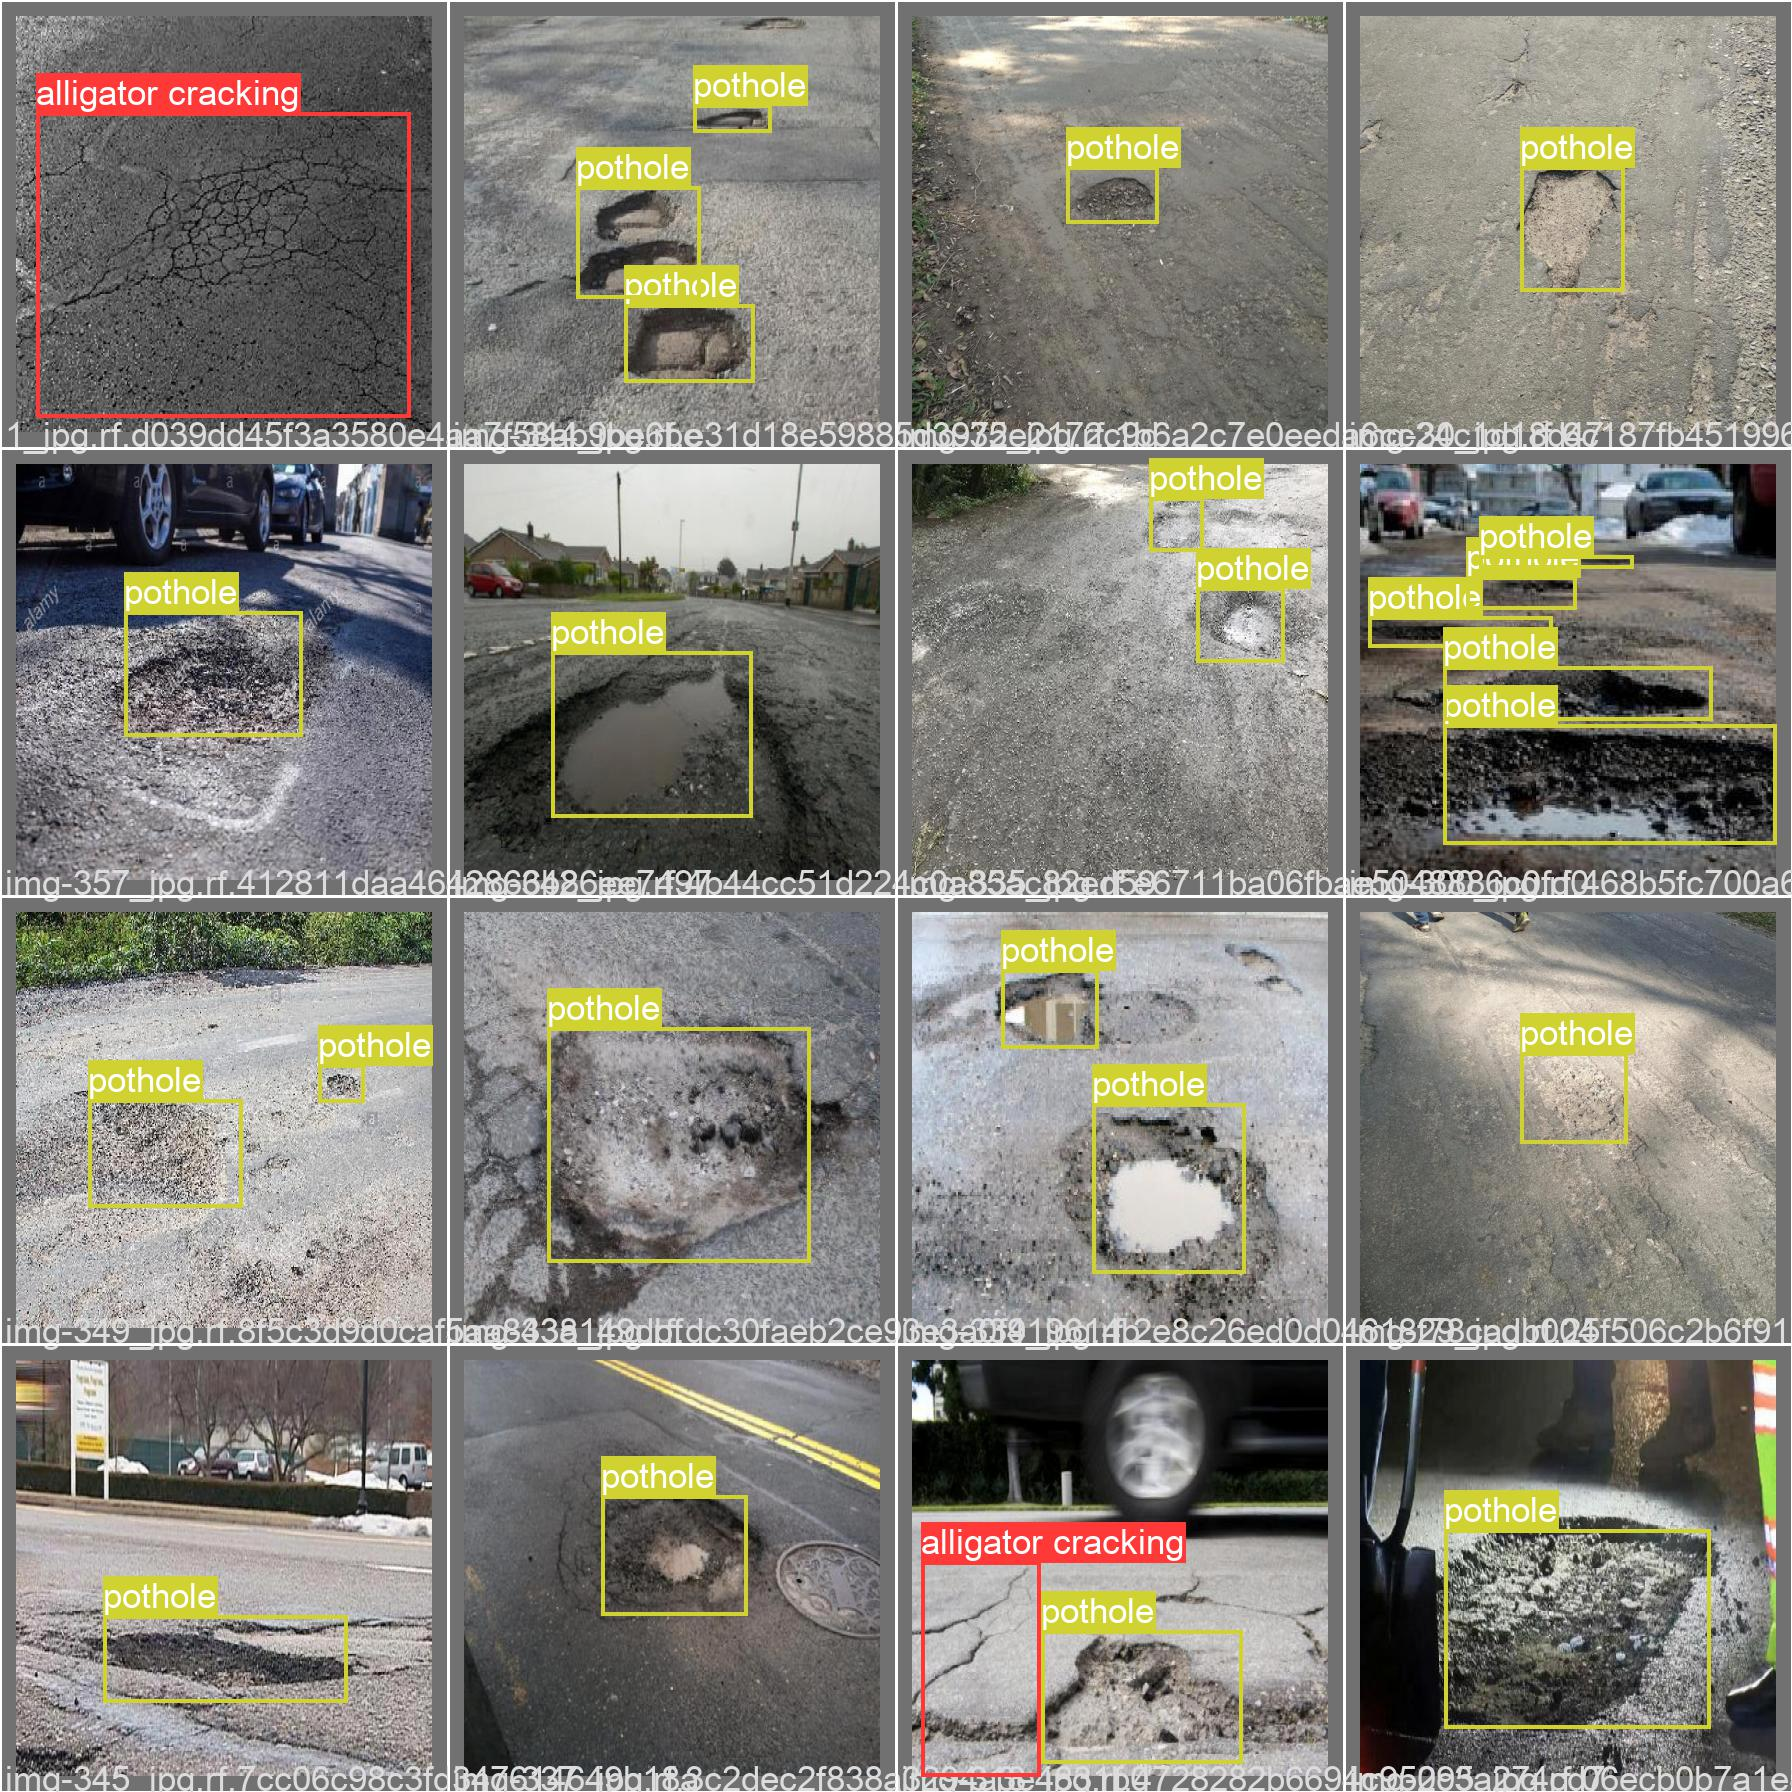

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/drive/MyDrive/Road/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


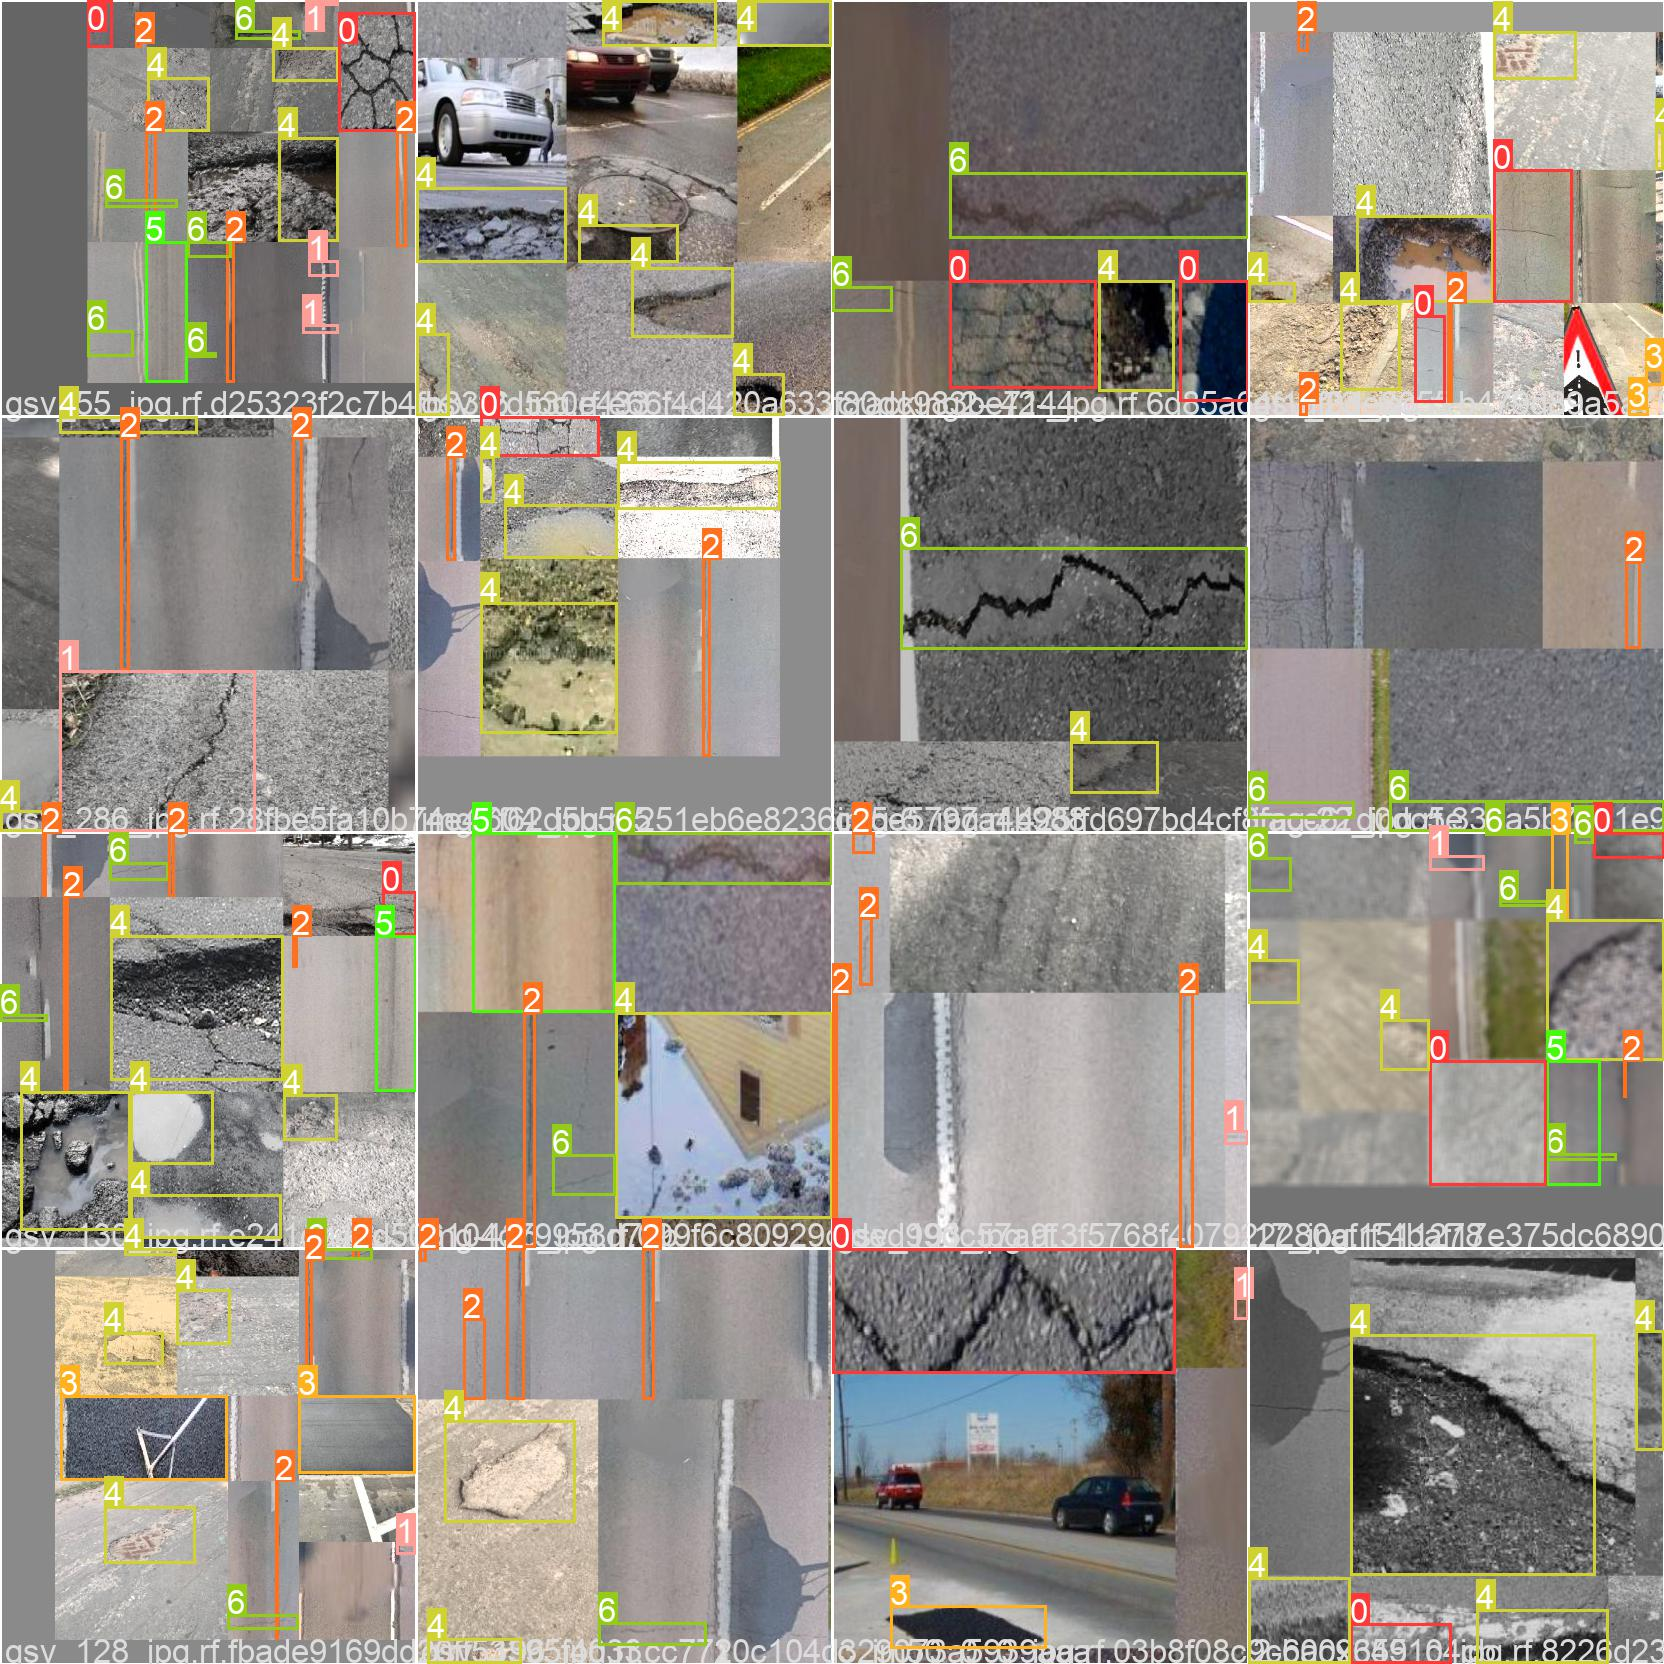

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/drive/MyDrive/Road/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [ ]:
%cd /content/drive/MyDrive/Road/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source ./pavement-cracks-1/test/images

/content/drive/MyDrive/Road/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=./pavement-cracks-1/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7262700 parameters, 0 gradients, 16.8 GFLOPs
image 1/165 /content/drive/MyDrive/Road/yolov5/pavement-cracks-1/test/images/11_jpg.rf.95574df05e2405a380117493a4329702.jpg: 416x416 1 pothole, Done. (0.009s)
image 2/165 /content/drive/MyDrive/Road/yolov5/pavement-cracks-1/test/images/16_jpg.rf.8a8e66db2043a760c4134d3fcc2e22e5.jpg: 416x416 2

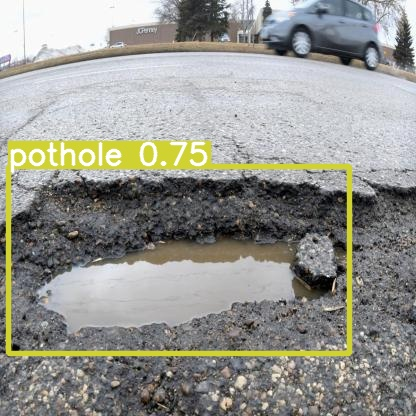

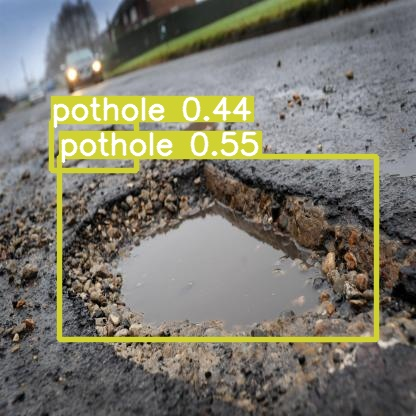

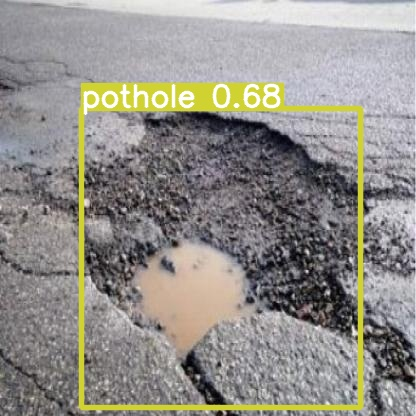

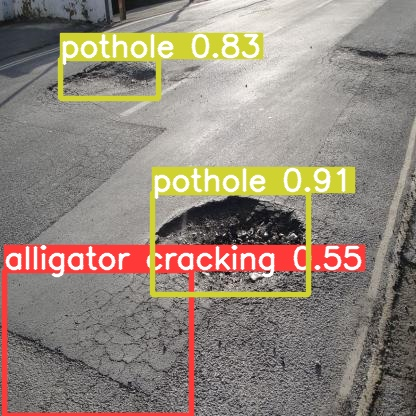

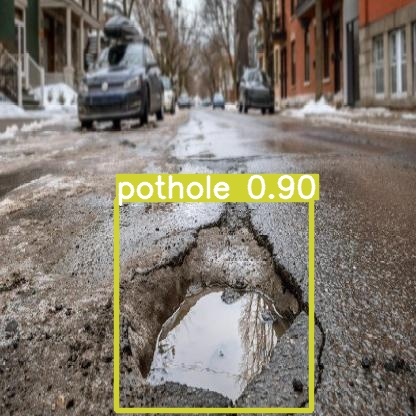

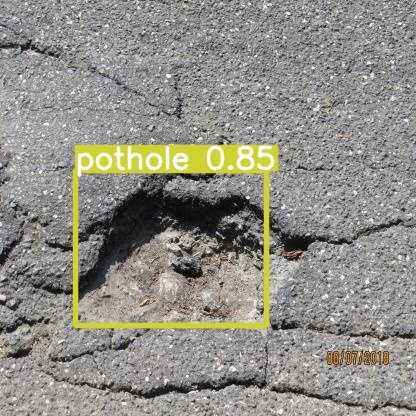

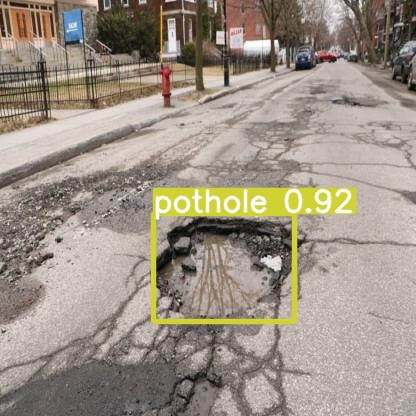

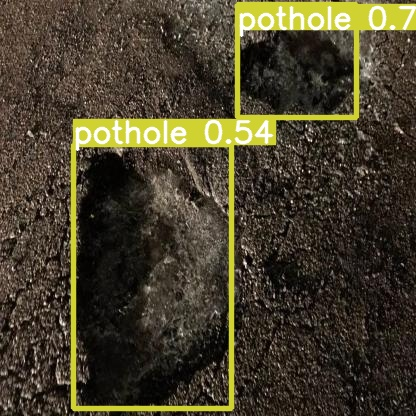

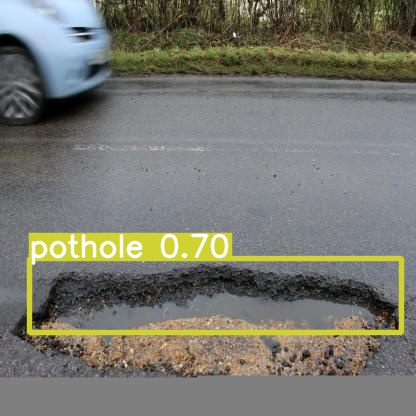

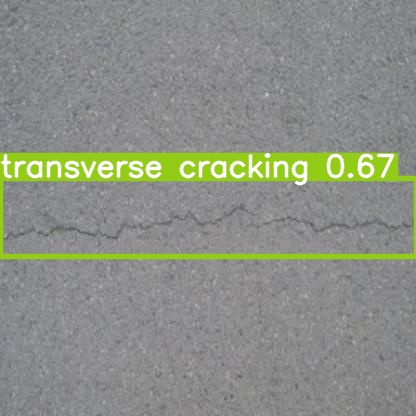

In [ ]:
import glob
from IPython.display import Image, display
c=0;
for imageName in glob.glob('/content/drive/MyDrive/Road/yolov5/runs/detect/exp3/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")
    c=c+1;
    if(c ==10):
      break;

In [ ]:
%cd /content/drive/MyDrive/Road/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source ./pavement-cracks-1/test/images --save-txt --nosave

/content/drive/MyDrive/Road/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=./pavement-cracks-1/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=True, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7262700 parameters, 0 gradients, 16.8 GFLOPs
image 1/165 /content/drive/MyDrive/Road/yolov5/pavement-cracks-1/test/images/11_jpg.rf.95574df05e2405a380117493a4329702.jpg: 416x416 1 pothole, Done. (0.009s)
image 2/165 /content/drive/MyDrive/Road/yolov5/pavement-cracks-1/test/images/16_jpg.rf.8a8e66db2043a760c4134d3fcc2e22e5.jpg: 416x416 2 p

In [ ]:
#initial the model
import os
import sys
from pathlib import Path

import torch
import torch.backends.cudnn as cudnn

ROOT = '/content/drive/MyDrive/Road/yolov5/'
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))  # add ROOT to PATH
#ROOT = Path(os.path.relpath(ROOT, Path.cwd()))  # relative

from models.common import DetectMultiBackend
from utils.dataloaders import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr, cv2,
                           increment_path, non_max_suppression, print_args, scale_coords, strip_optimizer, xyxy2xywh)
from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, time_sync


device='cuda:0'
weights='runs/train/yolov5s_results/weights/best.pt'
data='pavement-cracks-1/data.yaml'
conf_thres=0.4
iou_thres=0.45
imgsz=[416,416]

torch.no_grad()
# Load model
device = select_device(device)
model = DetectMultiBackend(weights, device=device, dnn=False, data=data, fp16=False)
stride, names, pt = model.stride, model.names, model.pt
imgsz = check_img_size(imgsz, s=stride)  # check image size


INFO:yolov5:YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

INFO:yolov5:Fusing layers... 
Fusing layers... 
INFO:yolov5:custom_YOLOv5s summary: 232 layers, 7262700 parameters, 0 gradients
custom_YOLOv5s summary: 232 layers, 7262700 parameters, 0 gradients


In [ ]:
import numpy as np
source='pavement-cracks-1/test/images'
dataset = LoadImages(source, img_size=imgsz, stride=stride, auto=pt)
bs = 1  # batch_size
vid_path, vid_writer = [None] * bs, [None] * bs

# Run inference
model.warmup(imgsz=(1 if pt else bs, 3, *imgsz))  # warmup
seen, windows, dt = 0, [], [0.0, 0.0, 0.0]
for path, im, im0s, vid_cap, s in dataset:
    t1 = time_sync()
    im = torch.from_numpy(im).to(device)
    im = im.half() if model.fp16 else im.float()  # uint8 to fp16/32
    im /= 255  # 0 - 255 to 0.0 - 1.0
    if len(im.shape) == 3:
        im = im[None]  # expand for batch dim
    t2 = time_sync()
    dt[0] += t2 - t1

    # Inference
    #visualize = increment_path(save_dir / Path(path).stem, mkdir=True) if visualize else False
    pred = model(im, augment=None, visualize=False)
    t3 = time_sync()
    dt[1] += t3 - t2

    # NMS
    pred = non_max_suppression(pred, conf_thres, iou_thres, None, False, max_det=1000)
    dt[2] += time_sync() - t3

    # Second-stage classifier (optional)
    # pred = utils.general.apply_classifier(pred, classifier_model, im, im0s)
    seen += 1
    p = path
    p = Path(p)  # to Path
    print(p)
    det=pred[0]
    if len(det):
        # Rescale boxes from img_size to im0 size
        pred2=scale_coords(im.shape[2:], det[:, :4], im0s.shape).round()
        print(det.shape)
        print('box: '+str(np.array(pred2.cpu())))
        print('class: '+str(det[:,-1].cpu()))
        print('confidence: '+str(np.array(det[:,-2].cpu())))
        #break;
            


/content/drive/MyDrive/Road/yolov5/pavement-cracks-1/test/images/11_jpg.rf.95574df05e2405a380117493a4329702.jpg
torch.Size([1, 6])
box: [[          8         166         349         353]]
class: tensor([4.])
confidence: [     0.7471]
/content/drive/MyDrive/Road/yolov5/pavement-cracks-1/test/images/16_jpg.rf.8a8e66db2043a760c4134d3fcc2e22e5.jpg
torch.Size([2, 6])
box: [[         59         156         376         339]
 [         51         121         136         170]]
class: tensor([4., 4.])
confidence: [    0.55029      0.4383]
/content/drive/MyDrive/Road/yolov5/pavement-cracks-1/test/images/19_JPG.rf.8dd531d8faeb04f8185ff5316bf55689.jpg
torch.Size([1, 6])
box: [[         81         108         360         407]]
class: tensor([4.])
confidence: [    0.68439]
/content/drive/MyDrive/Road/yolov5/pavement-cracks-1/test/images/20_JPG.rf.bc58319e153761f69aeab3a9f2e47f4f.jpg
torch.Size([3, 6])
box: [[        152         192         308         294]
 [         60          58         158       

In [ ]:
import numpy as np
from utils.augmentations import letterbox
imagePath="/content/drive/MyDrive/Road/yolov5/pavement-cracks-1/test/images/us14--38-_jpg.rf.7067e4519392d181489b82ca5f8586c4.jpg"
img0 = cv2.imread(imagePath)

# Padded resize
img = letterbox(img0, imgsz, stride, auto=pt)[0]

# Convert
img = img.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
img = np.ascontiguousarray(img)

bs = 1  # batch_size

# Run inference
model.warmup(imgsz=(1 if pt else bs, 3, *imgsz))  # warmup
seen, windows, dt = 0, [], [0.0, 0.0, 0.0]

im = torch.from_numpy(img).to(device)
im = im.half() if model.fp16 else im.float()  # uint8 to fp16/32
im /= 255  # 0 - 255 to 0.0 - 1.0
if len(im.shape) == 3:
    im = im[None]  # expand for batch dim
t2 = time_sync()
dt[0] += t2 - t1

# Inference
#visualize = increment_path(save_dir / Path(path).stem, mkdir=True) if visualize else False
pred = model(im, augment=None, visualize=False)
t3 = time_sync()
dt[1] += t3 - t2

# NMS
pred = non_max_suppression(pred, conf_thres, iou_thres, None, False, max_det=1000)
dt[2] += time_sync() - t3

# Second-stage classifier (optional)
# pred = utils.general.apply_classifier(pred, classifier_model, im, im0s)
seen += 1
p = path
p = Path(p)  # to Path
print(p)
det=pred[0]
if len(det):
    # Rescale boxes from img_size to im0 size
    pred2=scale_coords(im.shape[2:], det[:, :4], im0s.shape).round()
    print(det.shape)
    print('box: '+str(np.array(pred2.cpu())))
    print('class: '+str(det[:,-1].cpu()))
    print('confidence: '+str(np.array(det[:,-2].cpu())))
    #break;
        


/content/drive/MyDrive/Road/yolov5/pavement-cracks-1/test/images/us24--15-_jpg.rf.c2bc6423f5b4bc82d7e4fd8f4c0ff33d.jpg
torch.Size([5, 6])
box: [[        146           0         263         395]
 [        282         320         416         342]
 [          0         261         126         339]
 [          0          75         119          94]
 [        277          61         414          83]]
class: tensor([5., 6., 6., 6., 6.])
confidence: [    0.79018     0.69713     0.68201     0.59278      0.4347]


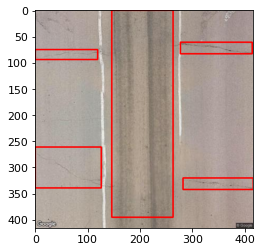

In [ ]:
# what 's the meaning of the numbers (answered)
# [ xmin , ymin , xmax, ymax ]
import cv2
import matplotlib.pyplot as plt 
image = cv2.imread('/content/drive/MyDrive/Road/yolov5/pavement-cracks-1/test/images/us14--38-_jpg.rf.7067e4519392d181489b82ca5f8586c4.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.rectangle(image, (146, 0), (263, 395), (255,0,0), 2)
cv2.rectangle(image, (282, 320), (416, 342), (255,0,0), 2)
cv2.rectangle(image, (0, 261), (126, 339), (255,0,0), 2)
cv2.rectangle(image, (0, 75), (119, 94), (255,0,0), 2)
cv2.rectangle(image, (277, 61), (414, 83), (255,0,0), 2)
plt.imshow(image)
plt.show()